## ドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/submit/'

/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/submit


## ライブラリのインポート

In [3]:
!pip install portalocker

import random
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## データの読み込み

csvからPytorchのDatasetを作る方法
参考
- https://dreamer-uma.com/pytorch-dataset/
- https://discuss.pytorch.org/t/loading-a-csv-with-a-column-of-strings-and-a-column-of-integers/151080/4

csv場所の定義

In [4]:
import pandas as pd


path_to_csv_file = './data/labels/labels_sensitivity_evaluation.csv'


PyTorchのDataset形式でcsvデータを読み込み(headerは自動で認識)

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = row[1]
        comment = row[3]
        sample = (label, comment)
        return sample

# データフレーム全体を読み込む
labels_dataframe = pd.read_csv(path_to_csv_file)

# 嗜好が3のものは除外する
labels_dataframe = labels_dataframe[labels_dataframe.iloc[:, 1]!=3]

# 2列目の値が1,2のものを0に変換
labels_dataframe.iloc[:, 1].replace([1, 2], 0, inplace=True)

# 2列目の値が4,5のものを1に変換
labels_dataframe.iloc[:, 1].replace([4, 5], 1, inplace=True)

# trainとtest用にデータを8:2に分割
trainval_df, test_df = train_test_split(labels_dataframe, test_size=0.2, random_state=42, stratify=labels_dataframe['label'])

# 分割したデータフレームをそれぞれのインスタンスに渡す。
trainval_data = CustomDataset(trainval_df)
test_data = CustomDataset(test_df)


ちゃんと読み込めているか確認

In [6]:
# for foo in trainval_data:
#     print(foo)

In [7]:
# for foo in test_data:
#     print(foo)

## trainとvalidにデータを分割

参考
- https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

In [8]:
train_size = int(0.8 * len(trainval_data))
valid_size = len(trainval_data) - train_size
train_dataset, vaild_dataset = torch.utils.data.random_split(trainval_data, [train_size, valid_size])

## 語彙リスト作成

単語数をカウント

In [9]:
# 単語をスペースで区切り，!"#$%&といった記号を除去する，すべて小文字化する，などの処理
# https://pytorch.org/text/stable/data_utils.html
tokenizer = get_tokenizer("basic_english")

counter = Counter()

for label, comment in train_dataset:
    counter.update(tokenizer(comment))

vocabulary = vocab(
    counter,
    min_freq=5,
    specials=('<unk>', '<PAD>', '<BOS>', '<EOS>')
)
# <unk>をデフォルトに設定することにより，min_freq回以上出てこない単語は<unk>になる
vocabulary.set_default_index(vocabulary['<unk>'])

word_num = len(vocabulary)

print(f"単語種数: {word_num}")
print(*vocabulary.get_itos()[:100], sep=', ')

単語種数: 84
<unk>, <PAD>, <BOS>, <EOS>, the, expression, is, scary, ., flash, strong, ,, eyes, are, a, bit, and, i, don, ', t, like, pose, gaze, at, it, difficult, to, see, cute, that, eye, in, for, an, out, fur, also, well-resolved, face, hard, identify, light, s, good, has, seems, be, something, on, there, not, too, nice, but, cat, from, posture, moment, of, looks, because, blurred, cool, black, which, focus, background, color, feel, well, text, unnecessary, pattern, beautiful, resolved, feeling, natural, angle, white, photo, soft, looking, with


text_transform()をcollate_batch()から呼び，単語のリストを辞書内インデックスのリストに変換

In [10]:
def text_transform(_text, max_length=256):
    # <BOS>と<EOS>の分 -2
    text = [vocabulary[token] for token in tokenizer(_text)][:max_length - 2]
    text = [vocabulary['<BOS>']] + text + [vocabulary['<EOS>']]

    return text, len(text)

def collate_batch(batch):
    label_list, text_list, len_seq_list = [], [], []

    for _label, _text in batch:
      label_list.append(_label)

      processed_text, len_seq = text_transform(_text)
      text_list.append(torch.tensor(processed_text))
      len_seq_list.append(len_seq)
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=1).T, torch.tensor(len_seq_list)

上で定義したcollate_batch()をDataLoaderに渡すことで，バッチに対してその処理を適用

In [11]:
batch_size = 32

train_dataloader = DataLoader(
   list(train_dataset),
   batch_size=batch_size,
   shuffle=True,
   collate_fn=collate_batch
)
valid_dataloader = DataLoader(
   list(vaild_dataset),
   batch_size=batch_size,
   shuffle=False,
   collate_fn=collate_batch
)

test_dataloader = DataLoader(
   list(test_data),
   batch_size=batch_size,
   shuffle=False,
   collate_fn=collate_batch
)


## 双方向LSTM実装

In [12]:
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))


class Embedding(nn.Module):
    # WRITE ME
    def __init__(self, emb_dim, vocab_size):
        super().__init__()
        self.embedding_matrix = nn.Parameter(torch.rand((vocab_size, emb_dim),
                                                        dtype=torch.float))

    def forward(self, x):
        return F.embedding(x, self.embedding_matrix)



class RNN(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim

        # 一様分布の時の処理
        glorot = 6 / (in_dim + hid_dim*2)
        self.W = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

    def function(self, h, x):
        return torch.tanh(torch.matmul(torch.cat([h, x], dim=1), self.W) + self.b)

    def forward(self, x, len_seq_max=0, init_state=None):
        x = x.transpose(0, 1)  # 系列のバッチ処理のため、次元の順番を「系列、バッチ」の順に入れ替える
        state = init_state

        if init_state is None:  # 初期値を設定しない場合は0で初期化する
            state = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)

        size = list(state.unsqueeze(0).size())
        size[0] = 0
        output = torch.empty(size, dtype=torch.float).to(x.device)  # 一旦空テンソルを定義して順次出力を追加する

        if len_seq_max == 0:
            len_seq_max = x.size(0)
        for i in range(len_seq_max):
            state = self.function(state, x[i])
            output = torch.cat([output, state.unsqueeze(0)])  # 出力系列の追加
        return output


class SequenceTaggingNet(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim, dropout_ratio):
        super().__init__()
        self.emb = Embedding(emb_dim, word_num)
        self.rnn1 = RNN(emb_dim, hid_dim)
        self.rnn2 = RNN(emb_dim, hid_dim)  # 層の追加
        self.rnn3= RNN(emb_dim, hid_dim)  # 層の追加
        self.rnn4 = RNN(emb_dim, hid_dim)  # 層の追加
        self.rnn5 = RNN(emb_dim, hid_dim)  # 層の追加
        self.linear = nn.Linear(hid_dim, 1)

        self.dropout = nn.Dropout(dropout_ratio)  # Dropoutの定義



    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)

        h = self.dropout(h)                          # Dropoutの適用

        h = self.rnn1(h, len_seq_max, init_state)
        h = self.dropout(h)                          # Dropoutの適用

        h = self.rnn2(h, len_seq_max)               # 層の追加
        h = self.dropout(h)                          # Dropoutの適用

        h = self.rnn3(h, len_seq_max)               # 層の追加
        h = self.dropout(h)                          # Dropoutの適用

        h = self.rnn4(h, len_seq_max)               # 層の追加
        h = self.dropout(h)                          # Dropoutの適用

        h = self.rnn5(h, len_seq_max)               # 層の追加
        h = self.dropout(h)                          # Dropoutの適用


        if len_seq is not None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]

        y = self.linear(h)



        return y


# 比較するためにこちらも実装
class SequenceTaggingNet2(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim, dropout_ratio):
        super().__init__()
        self.emb = nn.Embedding(word_num, emb_dim)  # nn.Embeddingの使用
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=False)  # nn.RNNの使用
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)


        if len_seq_max > 0:
            h, _ = self.rnn(h[:, 0:len_seq_max, :], init_state)
        else:
            h, _ = self.rnn(h, init_state)
        h = h.transpose(0, 1)
        if len_seq is None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]



        y = self.linear(h)

        return y





In [13]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [14]:
# NOTE: dataloaderはグローバルスコープ
def train(
    net,
    optimizer,
    n_epochs,
):
    for epoch in range(n_epochs):

        # スケジューラで学習率を更新する
        new_lr = scheduler(epoch)
        set_lr(new_lr, optimizer)

        losses_train = []
        losses_valid = []

        net.train()
        n_train = 0
        acc_train = 0
        for label, line, len_seq in train_dataloader:
            net.zero_grad()  # 勾配の初期化

            t = label.to(device) # テンソルをGPUに移動
            x = line.to(device) # ( batch, time )
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t * torch_log(y) + (1 - t) * torch_log(1 - y))

            loss.backward()  # 誤差の逆伝播

            optimizer.step()  # パラメータの更新

            losses_train.append(loss.tolist())

            n_train += t.size()[0]

        # Valid
        t_valid = []
        y_pred = []
        net.eval()
        for label, line, len_seq in valid_dataloader:

            t = label.to(device) # テンソルをGPUに移動
            x = line.to(device)
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

            pred = y.round().squeeze()  # 0.5以上の値を持つ要素を正ラベルと予測する

            t_valid.extend(t.tolist())
            y_pred.extend(pred.tolist())

            losses_valid.append(loss.tolist())

        print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}, Learning Rate: {}'.format(
            epoch,
            np.mean(losses_train),
            np.mean(losses_valid),
            f1_score(t_valid, y_pred, average='macro'),
            new_lr
        ))



In [15]:
emb_dim = 400
hid_dim = 100
n_epochs = 1000
warmup_length = round(n_epochs * 0.1, 0)

device = 'cuda'
weight_decay = 0 # 過学習抑制のためのL2 penalty
lr = 0.1
dropout_ratio = 0

net = SequenceTaggingNet2(word_num, emb_dim, hid_dim, dropout_ratio)
net.to(device)

# 学習率の更新定義
scheduler = CosineScheduler(epochs=n_epochs, lr=lr, warmup_length=warmup_length)

optimizer = optim.NAdam(net.parameters(), weight_decay = weight_decay, lr = lr)



In [16]:
train(net, optimizer, n_epochs)

EPOCH: 0, Train Loss: 0.705, Valid Loss: 0.712, Validation F1: 0.288, Learning Rate: 0.001
EPOCH: 1, Train Loss: 0.691, Valid Loss: 0.692, Validation F1: 0.460, Learning Rate: 0.002
EPOCH: 2, Train Loss: 0.674, Valid Loss: 0.670, Validation F1: 0.460, Learning Rate: 0.003
EPOCH: 3, Train Loss: 0.677, Valid Loss: 0.678, Validation F1: 0.332, Learning Rate: 0.004
EPOCH: 4, Train Loss: 0.665, Valid Loss: 0.667, Validation F1: 0.533, Learning Rate: 0.005000000000000001
EPOCH: 5, Train Loss: 0.665, Valid Loss: 0.675, Validation F1: 0.460, Learning Rate: 0.006
EPOCH: 6, Train Loss: 0.775, Valid Loss: 0.674, Validation F1: 0.460, Learning Rate: 0.007000000000000001
EPOCH: 7, Train Loss: 0.667, Valid Loss: 0.655, Validation F1: 0.460, Learning Rate: 0.008
EPOCH: 8, Train Loss: 0.667, Valid Loss: 0.645, Validation F1: 0.460, Learning Rate: 0.009
EPOCH: 9, Train Loss: 0.700, Valid Loss: 0.903, Validation F1: 0.311, Learning Rate: 0.010000000000000002
EPOCH: 10, Train Loss: 0.716, Valid Loss: 0.6

# testデータで性能検証

In [17]:
net.eval()

t_true = []
t_pred = []
for label, line, len_seq in test_dataloader:

    # t = label.to(device) # テンソルをGPUに移動
    x = line.to(device)
    len_seq.to(device)

    h = net(x, torch.max(len_seq), len_seq)
    y = torch.sigmoid(h).squeeze()

    # 予測値を格納
    t_pred.extend(y.detach().cpu().numpy())

    # labelを格納
    t_true.extend(label.numpy())



# numpy arraysに変換
t_pred = np.array(t_pred)
t_true = np.array(t_true)


# 予測の出力がロジットなので、確率に変換するためにシグモイド関数を適用
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

t_pred_sigmoid = sigmoid(t_pred)

### ROCカーブ

ROC AUC: 0.5384615384615385


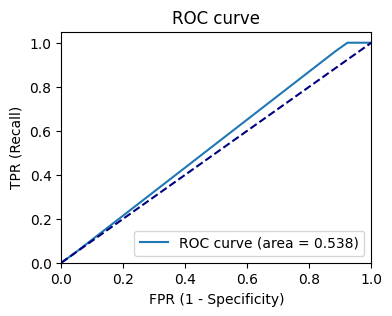

In [18]:
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(t_true, t_pred_sigmoid)
print(f"ROC AUC: {roc_auc}")

# ROCカーブの値を計算
fpr, tpr, thresholds = roc_curve(t_true, t_pred_sigmoid)

# ROCカーブをプロット
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Recall)')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### 閾値を変更した場合の各指標の値

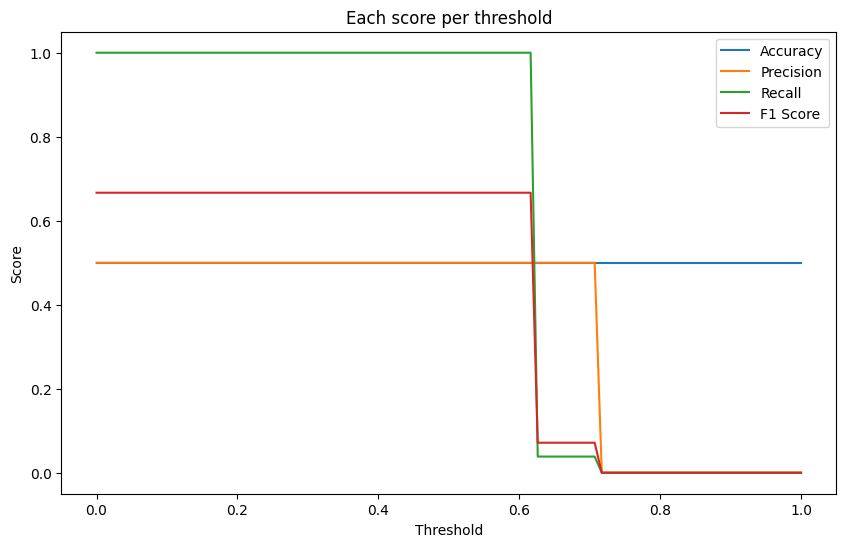

In [19]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 様々な閾値で値を計算
thresholds = np.linspace(0, 1, 100)
accuracies = []
precisions = []
recalls = []
f1_scores = []
for threshold in thresholds:
    t_pred_class = (t_pred_sigmoid > threshold).astype(int)
    accuracies.append(accuracy_score(t_true, t_pred_class))
    precisions.append(precision_score(t_true, t_pred_class))
    recalls.append(recall_score(t_true, t_pred_class))
    f1_scores.append(f1_score(t_true, t_pred_class))

# 各指標をプロット
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Each score per threshold')
plt.legend()
plt.show()



### 混同行列

In [20]:
# 指定した閾値で混同行列を計算
threshold = 0.619589535
t_pred_class = (t_pred_sigmoid > threshold).astype(int)
cm = confusion_matrix(t_true, t_pred_class)
print(f"混同行列の閾値 {threshold}:\n{cm}")

混同行列の閾値 0.619589535:
[[25  1]
 [25  1]]
